In [1]:
import torch
from torch import nn
from torch.nn import functional
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import utils
import numpy as np
from model import unet,unet_backbone

In [2]:
%load_ext autoreload
%autoreload 3

In [3]:
voc_dir = '../autodl-tmp/data/VOCdevkit/VOC2012'
# train_features, train_labels = utils.read_voc_images(voc_dir)

In [4]:
crop_size = (320, 480)
voc_train = utils.VOCSegDataset(True, crop_size, voc_dir)
voc_test = utils.VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [5]:
batch_size = 32
train_iter = DataLoader(voc_train, batch_size, shuffle=True)
test_iter = DataLoader(voc_test,batch_size,shuffle=False)
# for X, Y in train_iter:
#     print(X.shape[0])

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
channels = 32
classes = 21 # 21 classes
input_channels = 3
model = unet.Unet(input_channels,channels,classes).to(device)
model.apply(utils.init_weights)
# print(model)

Unet(
  (cblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (cblock5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3)

In [8]:
lr = 1e-4
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-3)
# optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=1e-3)

In [9]:
torch.manual_seed(17)
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    utils.train(train_iter, device, model, loss_fn, optimizer)
    utils.test(test_iter,device,model,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.899401  [    0/ 1114]
loss: 1.908220  [  960/ 1114]
Test Error: 
 pixel acc: 72.79%, mean acc: 17.92%, Avg loss: 1.662151 

Epoch 2
-------------------------------
loss: 1.611816  [    0/ 1114]
loss: 1.572444  [  960/ 1114]
Test Error: 
 pixel acc: 72.84%, mean acc: 18.20%, Avg loss: 1.512606 

Epoch 3
-------------------------------
loss: 1.633031  [    0/ 1114]
loss: 1.570053  [  960/ 1114]
Test Error: 
 pixel acc: 72.87%, mean acc: 18.21%, Avg loss: 1.446946 

Epoch 4
-------------------------------
loss: 1.790643  [    0/ 1114]
loss: 1.378305  [  960/ 1114]
Test Error: 
 pixel acc: 72.97%, mean acc: 18.21%, Avg loss: 1.336543 

Epoch 5
-------------------------------
loss: 1.415949  [    0/ 1114]
loss: 1.551760  [  960/ 1114]
Test Error: 
 pixel acc: 72.85%, mean acc: 18.07%, Avg loss: 1.305909 

Epoch 6
-------------------------------
loss: 1.197535  [    0/ 1114]
loss: 1.381549  [  960/ 1114]
Test Error: 
 pixel acc: 72.87%, mean ac

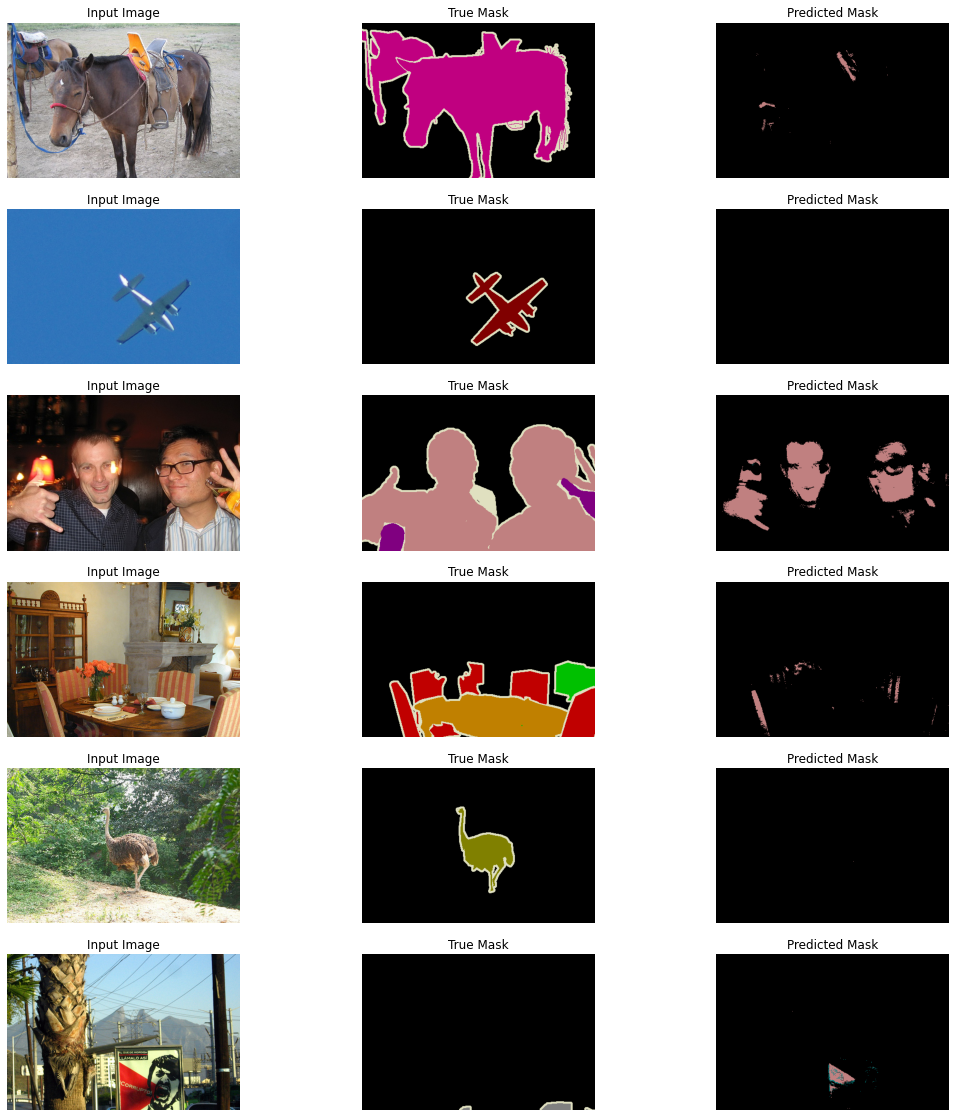

In [12]:
torch.manual_seed(17)
# 裁剪一些图片的一部分进行预测
test_images, test_labels = utils.read_voc_images(voc_dir, False)
n = 6
rows,cols = n,3
title = ['Input Image', 'True Mask', 'Predicted Mask']
plt.figure(figsize=(18, 20))
for i in range(n):
    idx = torch.randint(len(test_images),(1,)).item()
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[idx], *crop_rect)
    pred = utils.label2image(utils.predict(X,test_iter,device,model),device)
    img_list = [X.permute(1,2,0),
                torchvision.transforms.functional.crop(test_labels[idx],*crop_rect).permute(1,2,0),
                pred.cpu()]
    for j,img in enumerate(img_list):
        plt.subplot(rows,cols,i*cols+j+1)
        plt.title(title[j])
        # plt.imshow(transforms.ToPILImage()(img))
        plt.imshow(img.numpy())
        plt.axis('off')
plt.show()

In [13]:
torch.save(model,'Unet-50epochs.pt')

In [7]:
model = torch.load('Unet-50epochs.pt',map_location=device)

In [14]:
# mean iou
model.eval()

mean_iou = []
with torch.no_grad():
    for X,y in test_iter:
        X,y = X.to(device),y.to(device)
        pred = model(X)
        pred = torch.argmax(pred,1)
        iou = utils.iou(pred,y,21,ignore_background=True)
        iou = np.mean(iou)
        mean_iou.append(iou)
        print(f'this mean iou is :{iou}')
print(f'mean iou for all is: {np.mean(mean_iou)}')

this mean iou is :0.05472224265031941
this mean iou is :0.051745019903924605
this mean iou is :0.05271003141780576
this mean iou is :0.10164577114998599
this mean iou is :0.051645550254562786
this mean iou is :0.20589256154203128
this mean iou is :0.10489793588610138
this mean iou is :0.1110839943903714
this mean iou is :0.20579605538702425
this mean iou is :0.20528752139236706
this mean iou is :0.057000319181112355
this mean iou is :0.2532902762809535
this mean iou is :0.10328836571225349
this mean iou is :0.11004555809011796
this mean iou is :0.10442673238502194
this mean iou is :0.05291789791112411
this mean iou is :0.10036729655525192
this mean iou is :0.10436307803019518
this mean iou is :0.11232885702513343
this mean iou is :0.15392478072964505
this mean iou is :0.15689400951381977
this mean iou is :0.05228026500907622
this mean iou is :0.05230873934837197
this mean iou is :0.15061217514889363
this mean iou is :0.20629563154626998
this mean iou is :0.051659231979467146
this mean 